In [72]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import roc_auc_score

import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

## Загрузка данных

In [73]:
f = open(r'linear_train.txt','r',encoding='utf-8')
words=[]
target=[]
for line in f:
    words.append(line.split(', ')[0])
    target.append(line.split(', ')[1][0])

    
data=pd.DataFrame(words, columns=['name'])
data['tar']=target
data['tar']=data['tar'].astype(int)
target=pd.DataFrame(target, columns=['tar'])
target['tar']=target
target['tar']=target['tar'].astype('int')
f.close()


f1 = open(r'linear_test.txt','r',encoding='utf-8')
words1=[]
for line in f1:
    words1.append(line.split('\n')[0])
lin_test=pd.DataFrame(words1, columns=['name'])
f1.close()


data_res=data.copy()
target_res=target.copy()

In [74]:
data.head(15)

,name,tar
0,Аалтонен,1
1,Аар,0
2,Аарон,0
3,ААРОН,0
4,Аарона,0
5,Аарона,1
6,Аароне,0
7,Ааронов,0
8,Аахена,0
9,Абабков,1


## Формирование признаков

In [75]:
# Заглавная буква
def first_letter(data):
    data['big_sym']=[s.istitle() for s in data.name]
    data['big_sym']=data['big_sym'].astype('int')


first_letter(data)

In [76]:
(data[data['big_sym'] == 1]['tar']).value_counts()#['tar'] == 0)#.value_counts()

0    27423
1     8716
Name: tar, dtype: int64

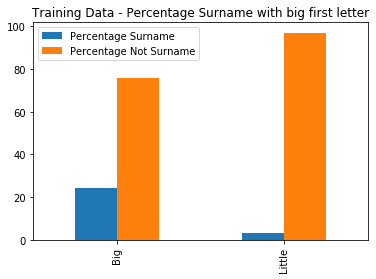

In [77]:
def plot_big_sym(data):
    title_b_distribution = round((data[data['big_sym'] == 1]['tar']).value_counts()[1]/len(data[data['big_sym'] == 1]) * 100, 2)
    title_l_distribution = round((data[data['big_sym'] == 0]['tar']).value_counts()[1]/len(data[data['big_sym'] == 0]) * 100, 2)
    big_sym_df = pd.DataFrame(
    { "Percentage Surname":{"Big": title_b_distribution,"Little": title_l_distribution},  
     "Percentage Not Surname":{"Big": 100-title_b_distribution,"Little": 100-title_l_distribution}})
    big_sym_df.plot.bar().set_title("Training Data - Percentage Surname with big first letter")
    
plot_big_sym(data)

Получается, что если буква маленькая, то слово почти наверняка не является фамилией. Наличие большой буквы практически не информативно.

In [78]:
# Длина слова

def word_len(data):
    data['len']=[len(s) for s in data.name]
    data['len']=data['len'].astype(int)

    
word_len(data)

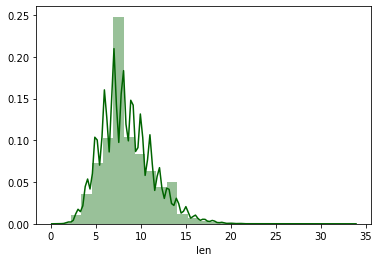

In [79]:
sns.distplot(data['len'],color='darkgreen',bins=27)

In [80]:
data.len.describe()

count    101408.000000
mean          8.450152
std           2.873555
min           1.000000
25%           6.000000
50%           8.000000
75%          10.000000
max          33.000000
Name: len, dtype: float64

In [81]:
def det_range(a):
    if a>=10:
        return '>10'
    if a==9:
        return '9'
    if a==8:
        return '8'
    if a==7:
        return '7'
    if a==6:
        return '6'
    if a==5:
        return '5'
    if a==4:
        return '4'
    if a<=3:
        return '<3'
    
def len_range(data):
    data['len_range']=[det_range(s) for s in data.len]
    data.drop('len', axis=1, inplace=True)
len_range(data)

In [82]:
data.len_range.value_counts()

>10    32359
7      15216
8      14602
9      12492
6      12291
5       8788
4       4230
<3      1430
Name: len_range, dtype: int64

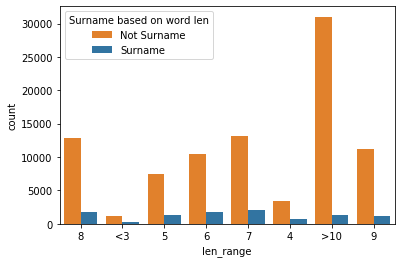

In [83]:
def plot_len(data):
    x = sns.countplot(x = "len_range", hue = "tar", data = data, palette=["C1", "C0"]).legend(labels = ["Not Surname", "Surname"])
    x.set_title("Surname based on word len")
    
plot_len(data)

In [84]:
data.tar.value_counts()

0    90770
1    10638
Name: tar, dtype: int64

Видно, что классы сильно несбалансированы и отличаются почти в 9 раз, воспльзуемся андерсэмплингом для балансирвоки классов и повторим визуализацию признаков

## Undersampling

In [85]:
ind=data[data['tar'] == 0].index
list_ind=list(ind)
drop_ind=set(list_ind[0:len(list_ind):9])^set(list_ind)
ind_1=pd.Int64Index(drop_ind)
print(len(drop_ind))

80684


In [86]:
#Сбалансируем классы
data.drop(drop_ind,inplace=True)
data.tar.value_counts()

1    10638
0    10086
Name: tar, dtype: int64

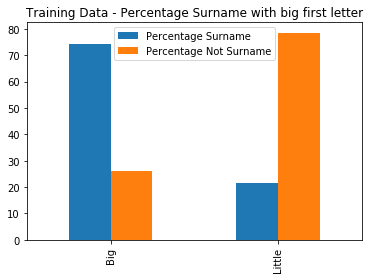

In [87]:
#Заглавная буква
first_letter(data)
plot_big_sym(data)

При сбалансированных классах большая буква почти всегда является показателем фамилии, а маленькая нет.

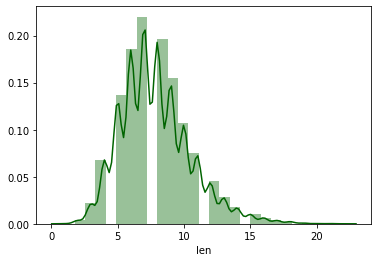

In [88]:
#Длина слова
word_len(data)
sns.distplot(data['len'],color='darkgreen',bins=27)

In [89]:
data.len.describe()

count    20724.000000
mean         7.853214
std          2.631821
min          1.000000
25%          6.000000
50%          8.000000
75%          9.000000
max         22.000000
Name: len, dtype: float64

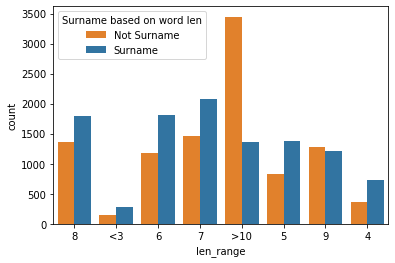

In [90]:
len_range(data)
plot_len(data)

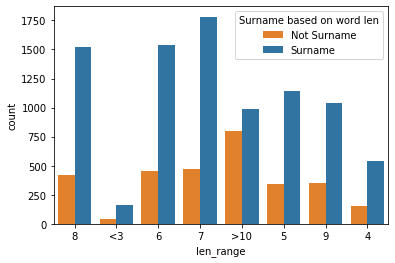

In [91]:
plot_len(data[data['big_sym']==1])

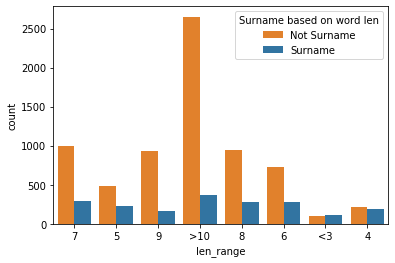

In [92]:
plot_len(data[data['big_sym']==0])

Видно, что слова длины меньше или равное 4 чаще являются фамилией, а слова длины более или равные 10 чаще являются не фамилией. Остальные категории слабо информативны, так что не будем их использовать.

In [93]:
#Наличие сторонних символов
def rubber(data):
    symbols=[r'"', '.', ',', '-']
    data['rubber']=[s not in symbols for s in data.name ]
    data['rubber']=data['rubber'].astype('int')
    
rubber(data)    

In [94]:
data.rubber.value_counts()

1    20724
Name: rubber, dtype: int64

При таком раскладе весьма бесполезный признак

In [95]:
data.drop('rubber', axis=1, inplace=True)

In [96]:
#Окончания 
def ending(data):
    data['ending']=[s[-3:] for s in data.name]
    
ending(data)

In [97]:
data['ending'].describe()

count     20724
unique     3664
top         ами
freq        462
Name: ending, dtype: object

In [98]:
a=data.ending.value_counts()
d=dict(a)
end_list=[]
for x in d:
    if d[x]>180:
        end_list.append(x)

In [99]:
def remove_end(end_list, a):
    if a not in end_list:
        return 0
    else:
        return a
    
def replace_end(data):
    data['new_end']=[remove_end(end_list, s) for s in data.ending ]

In [100]:
replace_end(data)

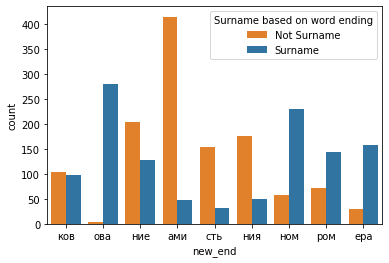

In [101]:
def plot_end(data):
    x = sns.countplot(x = "new_end", hue = "tar", data = data, palette=["C1", "C0"]).legend(labels = ["Not Surname", "Surname"])
    x.set_title("Surname based on word ending")
    
plot_end(data[data['new_end']!=0])

In [102]:
#Число гласных и согласных
let_list=["а","ы", "е", "ю", "я", "ё", "и", "о", "у", "э", "А","Ы", "Е", "Ю", "Я", "Ё", "И", "О", "У", "Э"]
def v_count_in_word(name,let_list):
    count=0
    for x in name:
        if x in let_list:
            count+=1
    return count
 
def c_count_in_word(name,let_list):
    count=0
    for x in name:
        if x not in let_list:
            count+=1
    return count

def let_count(data, let_list):        
    data['vowels_let']=[v_count_in_word(s,let_list) for s in data.name ]
    data['cons_let']=[c_count_in_word(s,let_list) for s in data.name ]
        

let_count(data, let_list)

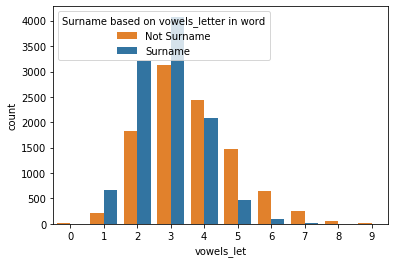

In [103]:
def plot_v_let(data):
    x = sns.countplot(x = "vowels_let", hue = "tar", data = data, palette=["C1", "C0"]).legend(labels = ["Not Surname", "Surname"])
    x.set_title("Surname based on vowels_letter in word")
    
plot_v_let(data)

Из полученных графиков можно сделать вывод, что в фамилиях тчаще всего встречаются 1,2,3 гласных буквы, а 5,6,7,8 в других словах

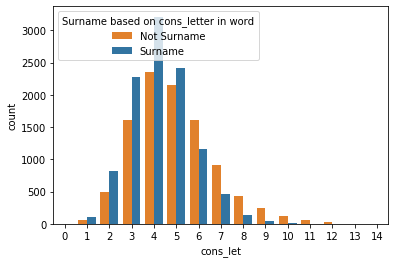

In [104]:
def plot_c_let(data):
    x = sns.countplot(x = "cons_let", hue = "tar", data = data, palette=["C1", "C0"]).legend(labels = ["Not Surname", "Surname"])
    x.set_title("Surname based on cons_letter in word")
    
plot_c_let(data)

Из полученных графиков можно сделать вывод, что в фамилиях тчаще всего встречаются 1,2,3,4 согласных буквы, а 6-12 в других словах

In [105]:
#Все буквы заглавные
def supper(data):
    data['supper']=[s.isupper() for s in data.name ]
    data['supper']=data['supper'].astype('int')
    
supper(data)



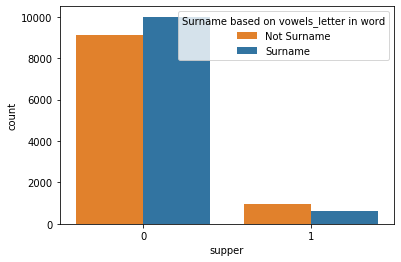

In [106]:
def plot_sup_let(data):
    x = sns.countplot(x = "supper", hue = "tar", data = data, palette=["C1", "C0"]).legend(labels = ["Not Surname", "Surname"])
    x.set_title("Surname based on vowels_letter in word")
    
plot_sup_let(data)

Практически неинформативный признак

In [107]:
data

,name,tar,big_sym,len_range,ending,new_end,vowels_let,cons_let,supper
0,Аалтонен,1,1,8,нен,0,4,4,0
1,Аар,0,1,<3,Аар,0,2,1,0
5,Аарона,1,1,6,она,0,4,2,0
9,Абабков,1,1,7,ков,ков,3,4,0
12,абажуры,0,0,7,уры,0,4,3,0
...,...,...,...,...,...,...,...,...,...
101383,ящерка,0,0,6,рка,0,3,3,0
101389,ящик,1,0,4,щик,0,2,2,0
101393,ящиках,0,0,6,ках,0,3,3,0
101402,ящура,0,0,5,ура,0,3,2,0


In [108]:
#Закодируем категориальные признаки
cat_feat=['len_range', 'new_end']
len_data=pd.get_dummies(data['len_range'],prefix='len')
ind=len_data.columns
data[ind]=len_data[ind]
data.drop('len_range', axis=1, inplace=True)

In [109]:

end_data=pd.get_dummies(data['new_end'],prefix='len')
ind1=end_data.columns
data[ind1]=end_data[ind1]
data.drop('new_end', axis=1, inplace=True)

In [110]:
#Удалим все ненужные столбцы
data.drop('ending', axis=1, inplace=True)
data.drop('name', axis=1, inplace=True)

In [111]:
balance_target=data['tar']
data.drop('tar', axis=1, inplace=True)

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20724 entries, 0 to 101403
Data columns (total 22 columns):
big_sym       20724 non-null int32
vowels_let    20724 non-null int64
cons_let      20724 non-null int64
supper        20724 non-null int32
len_4         20724 non-null uint8
len_5         20724 non-null uint8
len_6         20724 non-null uint8
len_7         20724 non-null uint8
len_8         20724 non-null uint8
len_9         20724 non-null uint8
len_<3        20724 non-null uint8
len_>10       20724 non-null uint8
len_0         20724 non-null uint8
len_ами       20724 non-null uint8
len_ера       20724 non-null uint8
len_ков       20724 non-null uint8
len_ние       20724 non-null uint8
len_ния       20724 non-null uint8
len_ном       20724 non-null uint8
len_ова       20724 non-null uint8
len_ром       20724 non-null uint8
len_сть       20724 non-null uint8
dtypes: int32(2), int64(2), uint8(18)
memory usage: 1.6 MB


## 

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
X_train ,  X_test ,  y_train ,  y_test   = train_test_split(data, balance_target, test_size=0.2)

In [114]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy')
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [115]:

train_preds_rf = rf.predict(X_train)
test_preds_rf = rf.predict(X_test)
print('Площадь под рок кривой на трейне',roc_auc_score(y_train, train_preds_rf))
print('Площадь под рок кривой на тесте',roc_auc_score(y_test, test_preds_rf))

Площадь под рок кривой на трейне 0.7845312807082644
Площадь под рок кривой на тесте 0.7748937432367243


Text(0.5, 1.05, 'Confusion_matrix for RF')

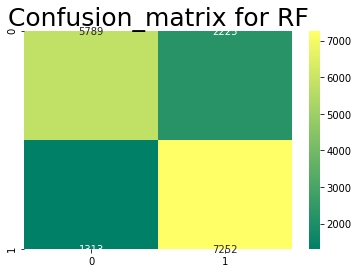

In [116]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_train,train_preds_rf),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for RF', y=1.05, size=25)

In [117]:

from sklearn.linear_model import Lasso
lclf=Lasso(alpha=0.0001)
lclf.fit(X_train, y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [118]:
train_preds2 = lclf.predict(X_train)
valid_preds2 = lclf.predict(X_test)
print('Ошибка на трейне',roc_auc_score(y_train, train_preds2))
print('Ошибка на тесте',roc_auc_score(y_test, valid_preds2))

Ошибка на трейне 0.8204665769520968
Ошибка на тесте 0.8225463162149125


In [119]:
def make_bin(data,lim):
    a=list()
    for x in data:
        if (x>lim):
            a.append(1)
        else:
            a.append(0)
    return np.array(a)
        

In [120]:
pred_try=make_bin(valid_preds2,0.8)

In [121]:
train_preds2 = lclf.predict(X_train)
pred_try=make_bin(valid_preds2,0.5)
print('Ошибка на трейне',roc_auc_score(y_train, train_preds2))
print('Ошибка на тесте',roc_auc_score(y_test, pred_try))

Ошибка на трейне 0.8204665769520968
Ошибка на тесте 0.7642804061038503


Text(0.5, 1.05, 'Confusion_matrix for RF')

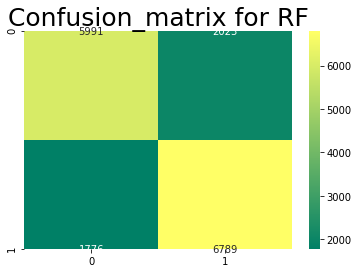

In [122]:
sns.heatmap(confusion_matrix(y_train,make_bin(train_preds2,0.6)),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for RF', y=1.05, size=25)

In [123]:
w=lclf.coef_

def vis_w(data,w):
    ind=data.columns
    weights=dict()
    for x,y in zip(ind,w):
        weights[x]=y
    return weights

unsort_weigth=vis_w(data,w)
weig_list=list(unsort_weigth.items())
weig_list.sort(key=lambda i: abs(i[1]))

In [124]:
weig_list

[('len_<3', -0.0),
 ('len_>10', 0.0),
 ('len_ния', -0.0),
 ('len_ром', 0.0),
 ('cons_let', -0.001745250788780265),
 ('len_4', -0.0026387755223231035),
 ('len_6', -0.009795389491800952),
 ('len_7', 0.013959448128026637),
 ('len_9', 0.021266996521882423),
 ('len_ном', 0.02495952371413593),
 ('len_8', 0.03194828690009098),
 ('len_5', -0.03613934834344326),
 ('vowels_let', -0.07656049510471663),
 ('len_ера', 0.08644165719783382),
 ('len_0', -0.09154014090419638),
 ('len_ние', 0.11405977476593829),
 ('len_ков', -0.12321600645217323),
 ('supper', 0.17128783913548765),
 ('len_сть', -0.20738076877723566),
 ('len_ами', -0.21815642519669834),
 ('len_ова', 0.222618654729478),
 ('big_sym', 0.5014073966135885)]

Так как лассо отбирает признаки, но не подходит для классификации, оставим только признаки, которым лассо присвоило большие веса

In [125]:
feat_list=['len_7', 'len_6', 'len_5', 'len_9', 'len_8', 'len_ном', 'vowels_let', 'len_0', 'len_ков', 'len_ера', 'len_ние', 
         'supper', 'len_ами', 'len_сть', 'len_ова', 'big_sym']

Обучим случайный лес на отобранных признаках и посмотрим влияет ли это на качество

In [126]:
X_train ,  X_test ,  y_train ,  y_test   = train_test_split(data.loc(axis=1)[feat_list], balance_target, test_size=0.2)

In [127]:
rf_short=RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_short.fit(X_train, y_train)

train_preds_rf_sh = rf_short.predict(X_train)
test_preds_rf_sh = rf_short.predict(X_test)
print('Площадь под рок кривой на трейне',roc_auc_score(y_train, train_preds_rf_sh))
print('Площадь под рок кривой на тесте',roc_auc_score(y_test, test_preds_rf_sh))

Площадь под рок кривой на трейне 0.7782475860202128
Площадь под рок кривой на тесте 0.7935302899890054


Text(0.5, 1.05, 'Confusion_matrix for RF')

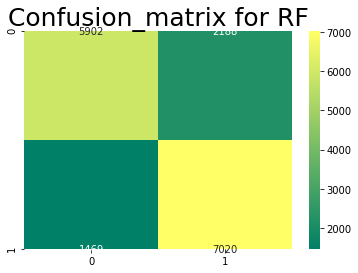

In [128]:
sns.heatmap(confusion_matrix(y_train,train_preds_rf_sh),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for RF', y=1.05, size=25)

На трейне рок аук не значительно вырос, а на тесте снизился на 0.1. Воспользуемся оверсэмплингом и оценим качество на нем.

## Баланс классов

In [129]:
data_bal=data_res.copy()
target_bal=target_res.copy()
    
def generate_feats(data, fitpr=0, end_list=[]):
    first_letter(data)
    word_len(data) 
    len_range(data)
    ending(data)     
    if fitpr==0:
        a=data.ending.value_counts()
        d=dict(a)
        end_list=[]
        for x in d:
            if d[x]>180:
                end_list.append(x)    
    replace_end(data)
    data['new_end']=[remove_end(end_list, s) for s in data.ending ]
    let_count(data, let_list)
    supper(data)
    
    cat_feat=['len_range', 'new_end']
    len_data=pd.get_dummies(data['len_range'],prefix='len')
    ind=len_data.columns
    data[ind]=len_data[ind]
    data.drop('len_range', axis=1, inplace=True)
      
    end_data=pd.get_dummies(data['new_end'],prefix='len')
    ind1=end_data.columns
    data[ind1]=end_data[ind1]
    data.drop('new_end', axis=1, inplace=True)
    data.drop('ending', axis=1, inplace=True)
    data.drop('name', axis=1, inplace=True)
    if fitpr==0:
        return end_list

end_list=generate_feats(data_bal)
data_bal.drop('tar', axis=1, inplace=True)

In [130]:
data_bal

,big_sym,vowels_let,cons_let,supper,len_4,len_5,len_6,len_7,len_8,len_9,...,len_тов,len_том,len_тор,len_тью,len_цам,len_цев,len_ции,len_цию,len_ция,len_ями
0,1,4,4,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,3,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,3,2,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101403,1,2,3,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101404,0,2,3,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101405,0,2,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101406,0,3,4,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
X_train_bal ,  X_test_bal ,  y_train_bal ,  y_test_bal   = train_test_split(data_bal, target_bal, test_size=0.2)

In [132]:
# Рассчитаем соотношение классов
data_res.tar.value_counts()

0    90770
1    10638
Name: tar, dtype: int64

In [133]:
rf_bal=RandomForestClassifier(n_estimators=150, n_jobs=-1, criterion='entropy',class_weight={0:1, 1:9})
rf_bal.fit(X_train_bal, y_train_bal)

C:\Program Files\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 9},
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=150, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [134]:
train_preds_rf_bal = rf_bal.predict(X_train_bal)
test_preds_rf_bal = rf_bal.predict(X_test_bal)
print('Площадь под рок кривой на трейне',roc_auc_score(y_train_bal, train_preds_rf_bal))
print('Площадь под рок кривой на тесте',roc_auc_score(y_test_bal, test_preds_rf_bal))

Площадь под рок кривой на трейне 0.8039451371386229
Площадь под рок кривой на тесте 0.7943952121603742


Text(0.5, 1.05, 'Confusion_matrix for RF')

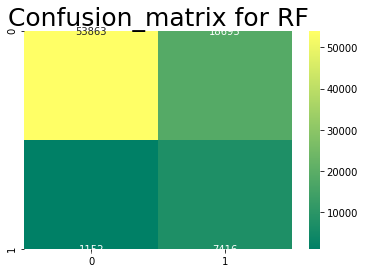

In [135]:
sns.heatmap(confusion_matrix(y_train_bal,train_preds_rf_bal),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for RF', y=1.05, size=25)

In [136]:
def write_to_file(name,test_pred):
    kaggle=pd.DataFrame(test_pred, columns = ['Id'])
    kaggle['Answer']=test_pred
    kaggle['Answer']=kaggle['Answer'].astype(float)
    kaggle=kaggle.drop('Id', 1)
    kaggle.to_csv(name)
    
lin_test_bal=lin_test.copy()
                  
generate_feats(lin_test,1,end_list)
                  

In [140]:
lclf_bal=Lasso(alpha=0.000 1)
lclf_bal.fit(X_train_bal, y_train_bal)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [144]:
pred=lclf_bal.predict(lin_test)
write_to_file('try2',pred)